###  Trotterized Ising model for open line in 1D 
 Following from the Schrödinger equation, the time evolution of a system initially in the state $\vert\psi(0)\rangle$ takes the form:

$$
\vert \psi(t) \rangle = e^{-i H t} \vert \psi(0) \rangle \text{,}
$$

where $H$ is the time-independent Hamiltonian under which the system is submitted. We consider a Hamiltonian that can be written as a weighted sum of Pauli terms $H=\sum_j a_j H_j$, with $H_j$ representing a tensor product of Pauli terms acting on $n$ qubits. Thus, the sequence of gates that approximate a single evolution step is found under the assumption that the product of matrix exponentials is a good approximation for the sum of matrix exponentials:

$$
\vert \psi(t) \rangle \approx \left(\prod_j e^{-i a_j H_j t/r} \right)^r \vert\psi(0) \rangle \text{,}
$$

where $t/r$ is the time slice (evolution step) that we are choosing. As a result, a gate to be applied $r$ times is created. A smaller timestep leads to a more accurate approximation. However, this also leads to deeper circuits which, in practice, leads to more error accumulation, becoming a critical aspect especially on NISQ devices. For the purposes of this tutorial, all simulations are Statevector simulator, which doesn't include any shot or hardware noise.

We will follow paper by Jamadagni at al.: [arXiv:2401.13625v1](https://arxiv.org/html/2401.13625v1).
The Transverse Field Ising Model (TFIM) Hamiltonian for 1D  open chain of length N (without periodic boundary condition) is
$$
H_{TFIM} = -  \sum_{i=0}^{N-2} \sigma_z^i \sigma_z^{i+1} - g(t) \sum_{j=0}^{N-1} \sigma_x^i  \text{,}
$$
where $ g(t)= -t/\tau_Q $ and $\tau_Q$ being the rate of the rate of the quanch. Since $g(t)$ is time-dependent, we'll treat it as a constant for each small time step.

In [147]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import TrotterQRTE
from qiskit_algorithms import TimeEvolutionProblem
from qiskit.quantum_info import Statevector
from time import time
import numpy as np

In [148]:
N = 9  # Number of qubits
J = 1.0  # Interaction strength
tau_Q = 2.0  # Quench time
final_time = 4.0  # Total evolution time
num_timesteps = 100  # Number of time steps
dt = final_time / num_timesteps  # Time step size

# Initialize list for Hamiltonians at each time step
HL = []

for step in range(num_timesteps):
    t = step * dt
    g_t = -t / tau_Q

    pauli_strings = []
    coefficients = []

    # Interaction terms for chain without periodic boundary
    for i in range(N-1):
        z_term = ['I'] * N
        z_term[i] = 'Z'
        z_term[(i + 1) % N] = 'Z'  # Periodic boundary conditions
        pauli_strings.append(''.join(z_term))
        coefficients.append(-J)

    # Transverse field terms
    for i in range(N):
        x_term = ['I'] * N
        x_term[i] = 'X'
        pauli_strings.append(''.join(x_term))
        coefficients.append(-g_t)

    H = SparsePauliOp.from_list(zip(pauli_strings, coefficients))
    HL.append(H)
# HL

In [149]:
print('1st H-step:\n',HL[0])

1st H-step:
 SparsePauliOp(['ZZIIIIIII', 'IZZIIIIII', 'IIZZIIIII', 'IIIZZIIII', 'IIIIZZIII', 'IIIIIZZII', 'IIIIIIZZI', 'IIIIIIIZZ', 'XIIIIIIII', 'IXIIIIIII', 'IIXIIIIII', 'IIIXIIIII', 'IIIIXIIII', 'IIIIIXIII', 'IIIIIIXII', 'IIIIIIIXI', 'IIIIIIIIX'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j,
  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
  0.+0.j])


In [150]:
print('last H-step:\n',HL[-1])

last H-step:
 SparsePauliOp(['ZZIIIIIII', 'IZZIIIIII', 'IIZZIIIII', 'IIIZZIIII', 'IIIIZZIII', 'IIIIIZZII', 'IIIIIIZZI', 'IIIIIIIZZ', 'XIIIIIIII', 'IXIIIIIII', 'IIXIIIIII', 'IIIXIIIII', 'IIIIXIIII', 'IIIIIXIII', 'IIIIIIXII', 'IIIIIIIXI', 'IIIIIIIIX'],
              coeffs=[-1.  +0.j, -1.  +0.j, -1.  +0.j, -1.  +0.j, -1.  +0.j, -1.  +0.j,
 -1.  +0.j, -1.  +0.j,  1.98+0.j,  1.98+0.j,  1.98+0.j,  1.98+0.j,
  1.98+0.j,  1.98+0.j,  1.98+0.j,  1.98+0.j,  1.98+0.j])


In [151]:
# Prepare the Initial State, all qubits in the $\ket{0}$ state
#initPatt= ['0']*N
initPatt= ''.join(['1' if i==2 else '0' for i in  range(N)])  # single bit
#initPatt= ''.join(['1' if i==N//2 or i+1==N//2 else '0' for i in  range(N)])  # 2bit in the middle
initial_state = Statevector.from_label(initPatt)
print('N=%d initPatt:%s'%(N,initPatt))

N=9 initPatt:001000000


In [152]:
problem = TimeEvolutionProblem(
    HL,
    initial_state=initial_state,
    time=final_time
)

Let compute exact Trotter evolution.  We compute this exponential using SciPy's linalg.expm function, and then we let the initial system evolve using the Statevector's evolve method. This becomes too costly to be performed on larger systems very quickly.

In [153]:
import scipy as sc
# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, num_timesteps)

# We compute the exact evolution using the exp
T0=time()
exact_evolution = []
for i,t in enumerate(exact_times):
    H_array = HL[i].to_matrix()
    exact_evolution.append(initial_state.evolve(sc.linalg.expm(-1j * t * H_array)) )
T1=time()
print('elaT=%.1f sec'%(T1-T0))

elaT=24.3 sec


In [154]:
magnetization_op = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1.0) for i in range(0, N)], num_qubits=N)
correlation_op = SparsePauliOp.from_sparse_list(
    [("ZZ", [i, i + 1], 1.0) for i in range(0, N - 1)], num_qubits=N) / (N - 1)

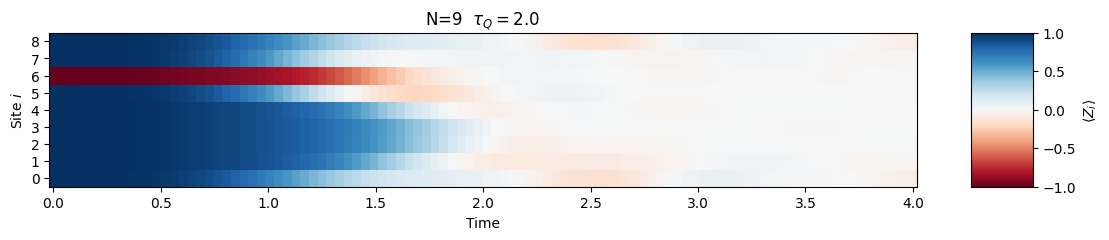

In [155]:
import matplotlib.pyplot as plt
from matplotlib import cm

# An inner list comprehension loops over the terms of the SparsePauliOp magnetization_op,
# which corresponds to the magnetization of each one of the sites
magnetizations = np.real(
    [[sv.expectation_value(term) for term in magnetization_op] for sv in exact_evolution]
)
fig, ax = plt.subplots(figsize=(14, 2))
# Create the 2-dim xx and yy arrays tiling the grid with the x and y values
xx, yy = np.meshgrid(exact_times, np.arange(N))
c = ax.pcolor(xx, yy, magnetizations.T, vmin=-1, vmax=+1, cmap="RdBu")
# Force the figure to have all y ticks from 0 to 5
ax.set_yticks(np.arange(N))
tit=r'N=%d  $\tau_Q=%.1f$ '%(N,tau_Q)
ax.set(ylabel="Site $i$",xlabel="Time",title=tit)

fig.colorbar(c, ax=ax, label="$\\langle Z_i \\rangle$", aspect=2.5)